## Import Libraries

In [2007]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV



%matplotlib inline

## Load the Data

In [2258]:
df = pd.read_csv("4.csv")

In [2259]:
df.shape

(6529, 18)

In [2260]:
df.drop('Unnamed: 0', axis=1 ,inplace=True)


In [2261]:
df.head(2)

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Defender Left-Back,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,4,35000000,42000000,2,1
1,Manchester United,Defender Left-Back,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,3,22000000,22000000,2,1


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [2209]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [2210]:
df['age']=df['age'].astype(int)
df['height'] = df['height'].astype(int)

In [2211]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = [ 'team','position']
numeric_features = ['height', 'age', 'appearance','goals', 'assists', 'yellow cards','second yellow cards', 'red cards', 'goals conceded','clean sheets', 'minutes played','days_injured','games_injured','award','current_value','highest_value','position_encoded','winger']

In [2212]:
for i in categorical_features:
    print(df[i].value_counts())

team
Royal AM FC               30
Al-Batin FC               28
Gangwon FC                28
Daejeon Hana Citizen      28
Jeonbuk Hyundai Motors    28
                          ..
Swansea City              12
Manchester City           11
Paris Saint-Germain       11
Gaziantep FK               5
Hatayspor                  5
Name: count, Length: 374, dtype: int64
position
Attack Centre-Forward         1294
midfield-CentralMidfield      1106
midfield-DefensiveMidfield     867
Defender Left-Back             774
midfield-AttackingMidfield     745
Attack-RightWinger             695
Attack-LeftWinger              694
midfield-RightMidfield          97
midfield-LeftMidfield           97
Attack-SecondStriker            62
midfield                        58
Attack                          40
Name: count, dtype: int64


In [2213]:
df.dtypes

team                 object
position             object
height                int64
age                   int64
appearance            int64
goals               float64
assists             float64
red cards           float64
clean sheets        float64
minutes played        int64
days_injured          int64
games_injured         int64
award                 int64
current_value         int64
highest_value         int64
position_encoded      int64
winger                int64
dtype: object

In [2214]:
df.head(2)

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Defender Left-Back,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,4,35000000,42000000,2,1
1,Manchester United,Defender Left-Back,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,3,22000000,22000000,2,1


In [2215]:
df.shape

(6529, 17)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [2216]:
categorical_features

['team', 'position']

In [2217]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [2218]:
df.shape

(6529, 401)

In [2219]:
df.head(2)

,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,...,position_Attack-LeftWinger,position_Attack-RightWinger,position_Attack-SecondStriker,position_Defender Left-Back,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,...,False,False,False,True,False,False,False,False,False,False
1,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,...,False,False,False,True,False,False,False,False,False,False


#### 3. Feature selection

In [2220]:
correlation = df.corr()
print(correlation['current_value'].sort_values(ascending=False))

current_value                  1.000000
highest_value                  0.839764
minutes played                 0.431664
appearance                     0.417284
award                          0.285266
                                 ...   
position_Attack               -0.033150
position_Defender Left-Back   -0.038949
position_midfield             -0.039939
age                           -0.047510
clean sheets                        NaN
Name: current_value, Length: 401, dtype: float64


In [2221]:
# Set the correlation threshold
threshold = 0.25 # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['appearance', 'minutes played', 'award', 'current_value',
       'highest_value'],
      dtype='object')

In [2222]:
selected_features = ['age', 'appearance', 'minutes played', 'current_value', 'highest_value', 'team_AFC Bournemouth', 'team_RC Strasbourg Alsace', 'team_Stade Rennais FC']

In [2223]:
df = df[selected_features]
df.head()

,age,appearance,minutes played,current_value,highest_value,team_AFC Bournemouth,team_RC Strasbourg Alsace,team_Stade Rennais FC
0,27,74,5854,35000000,42000000,False,False,False
1,23,89,7132,22000000,22000000,False,False,False
2,22,34,2686,10000000,12000000,False,False,False
3,31,101,7928,50000000,80000000,False,False,False
4,26,76,4687,25000000,35000000,False,False,False


#### 4. Prepare train and test data

In [2224]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [2225]:
X.shape

(6529, 7)

## Buliding the Model

In [2226]:
model = LinearRegression()

In [2227]:
ridge_model = Ridge()

In [2228]:
lasso_model = Lasso() 

In [2229]:
param_grid = {
    'alpha': [0, 0.0000003, 0.0002, 0.001, 0.01, 0.5, 1, 5,6]  # Regularization strength
}
grid_search_ridge = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=10,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [2230]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

## Test the Model

In [2231]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

In [2232]:
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [2233]:
lasso_model.fit(X_train_scaled, y_train)

Lasso()

In [2234]:
grid_search_ridge.fit(X_train_scaled, y_train)


Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5,
                                   6]},
             scoring='neg_mean_squared_error', verbose=1)

In [2235]:
grid_search_lasso.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5,
                                   6]},
             scoring='neg_mean_squared_error', verbose=1)

In [2236]:
y_pred_ridge = ridge_model.predict(X_test_scaled)


In [2237]:
y_pred_lasso = lasso_model.predict(X_test_scaled)


In [2238]:
print("Best parameters found: ", grid_search_ridge.best_params_)

# Best model
best_ridge = grid_search_ridge.best_estimator_

Best parameters found:  {'alpha': 0}


In [2239]:
print("Best parameters found: ", grid_search_lasso.best_params_)

# Best model
best_lasso = grid_search_lasso.best_estimator_


Best parameters found:  {'alpha': 0}


In [2240]:
y_pred_ridge_cv = best_ridge.predict(X_test_scaled)


In [2241]:
y_pred_lasso_cv = best_lasso.predict(X_test_scaled)


## Interpretation of the Model

In [2242]:
model.coef_

array([-1731628.17869528, -1718216.90053378,  2795220.41553649,
        7455695.08590569,    95438.37269207,    57753.12134816,
         172148.31604342])

In [2243]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-1.731628e+06
appearance,-1.718217e+06
minutes played,2.795220e+06
highest_value,7.455695e+06
team_AFC Bournemouth,9.543837e+04
team_RC Strasbourg Alsace,5.775312e+04
team_Stade Rennais FC,1.721483e+05


In [2244]:
print(model.intercept_) 

3963517.1357457405


In [2245]:
coeff_df = pd.DataFrame(best_lasso.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-1.731628e+06
appearance,-1.718217e+06
minutes played,2.795220e+06
highest_value,7.455695e+06
team_AFC Bournemouth,9.543837e+04
team_RC Strasbourg Alsace,5.775312e+04
team_Stade Rennais FC,1.721483e+05


## Evaluating the Model 

1. Mean Square Error

In [2246]:
y_base = [y_train.mean()] * len(y_test)

In [2247]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 94040690598953.95


In [2248]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 21906518212223.41
Mean Squared Error for testing: 20778925275266.426


2. Mean Absolute Error

In [2249]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 4750991.227692098


In [2250]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 2401582.3687976603
Mean Absolute Error for testing: 2362685.678751711


3. Root Mean Squared Error

In [2251]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 2179.676863136391


In [2252]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 4680439.959258468
Root Mean Squared Error for testing: 4558390.645311832


4. R Square

In [2262]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.7406964488736584
R Square for testing: 0.7790293236113071


#### Predictions vs. Real Values

In [2254]:
predictions = model.predict(X_test_scaled)
#predictions

In [2255]:
predictions_ridge = best_ridge.predict(X_test_scaled)


In [2256]:
Real_Values = np.array(y_test)
#Real_Values

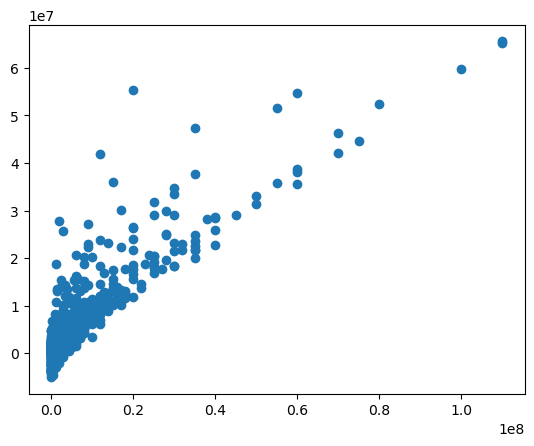

In [2257]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram